# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [83]:
#use this cell to import additional libraries or define helper functions
import datetime
import time
from sklearn.metrics import mean_squared_error

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 1 in this assignment. 

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [84]:
#Load your data into a pandas dataframe here
df = pd.read_csv('/content/household_power_consumption.txt',sep = ';',low_memory=False,)

df.head() #check first 5 rows of the dataset.

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00000


In [85]:
#convert datetime to epoch/unix time

# combine date and time columns into a single datetime column
df['datetime'] = df['Date'] + ' ' + df['Time']

# convert datetime column to datetime object
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')

df['time'] = 0

# convert datetime column to unix time
for i, row in df.iterrows():
    unix_time = time.mktime(row['datetime'].timetuple())
    df.at[i, 'time'] = unix_time


# delete datetime column that we have created to converte date time into unix
df.drop('datetime', axis=1, inplace=True)

## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: 
- ***ph*** is the time lag (or lag period) used in the linear regression model. It represents the number of time units that the predictor variable (in this case, time) is shifted by when making predictions. In this case, it is set to be 5 minutes, which means that the time column is shifted by 5 minutes when making predictions for GAP. 

- ***mu*** is the mean value of the predictor variable (time) in the linear regression model. It is used to normalize the predictor variable by subtracting it from each value in the time column before making predictions.


**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [121]:
ts = pd.DataFrame(df.time)
ys = pd.DataFrame(df.Global_active_power)

ph =  5 * 60 # 5 minutes in seconds
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:
- In an exponential moving average (EMA) with a smoothing factor of mu = 0.9, the weight of each data point in the prediction decreases exponentially as the data point becomes older.
- The weight of the first data point in the prediction of the 5000th data point can be calculated by multiplying the smoothing factor mu by the power of the number of time steps between the first data point and the last data point.

- In this case, the time period (ph) is set to be 5 minutes which is equal to 300 seconds. So the weight of the first data point on the last prediction (5000th data point) can be calculated as follows:

- weight of first data point = mu^(5000-1)/300 = 0.1727936117

- In this case, the weight of the first data point on the last prediction is approximately 0.1727936117 which is a  small value and the first data point has little impact on the last prediction in this limited dataset.




**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [122]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**((ns-k)/ph)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp.values.reshape(-1, 1), ys_tmp.values, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = df['time'].iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

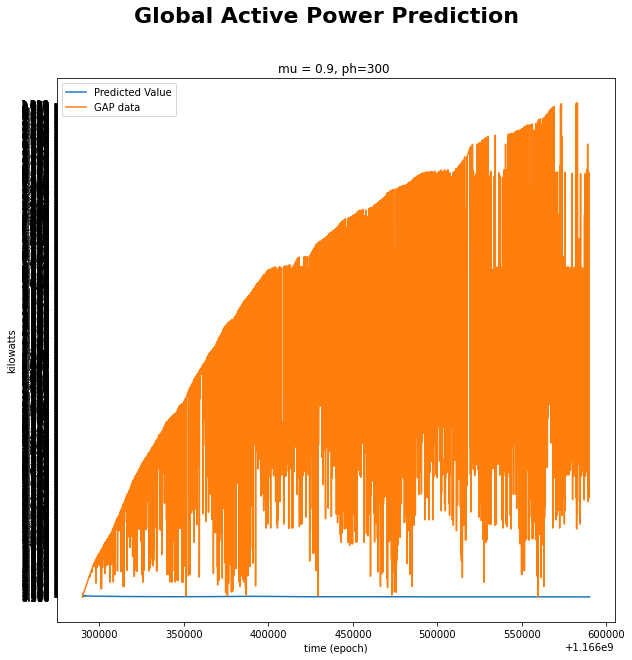

In [123]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the RMSE for our predictions.**

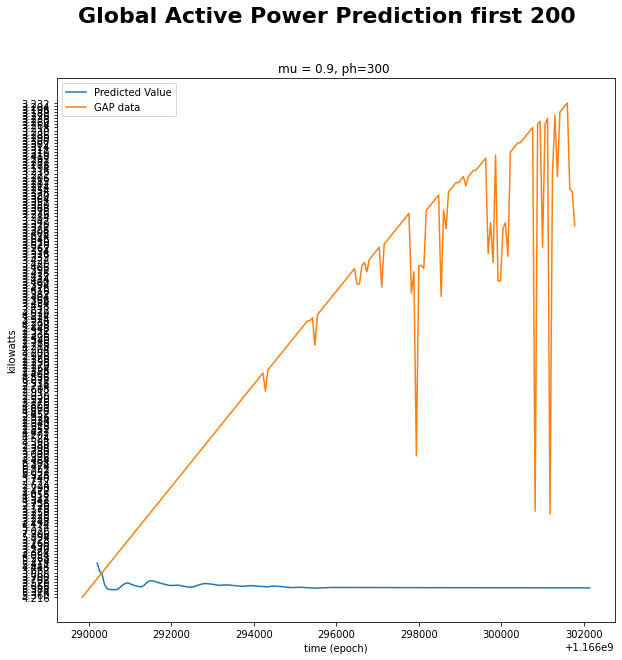

In [124]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction first 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


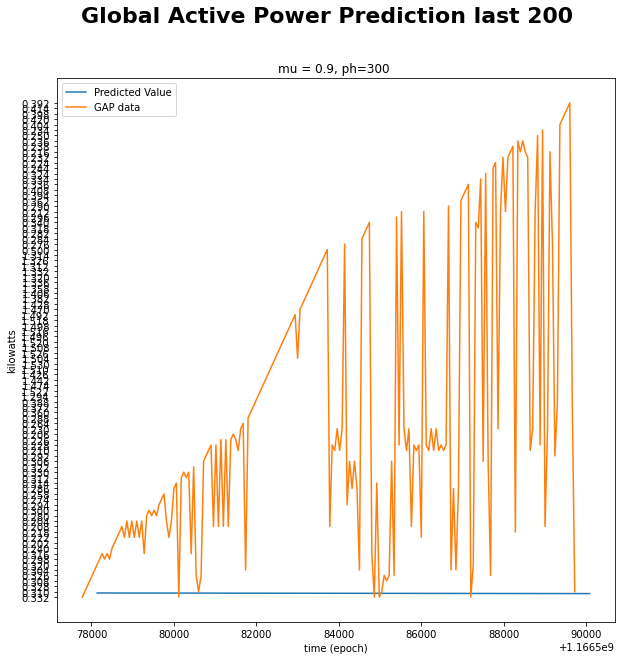

In [125]:
#Plot last 200 data points/predictions

# create a new figure and axis object for the predicted data
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[4799:4999,0], ys.iloc[4799:4999,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [126]:
#Calculate RMSE of predictions of last 200 data points
rmse = np.sqrt(mean_squared_error(ys.iloc[:4999,0], yp_pred))
print("RMSE: ", rmse)

RMSE:  1.1994162896855904


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the RMSE tell you?**

A: 
- After looking at the charts carefully we can observer that the line of our last 200 observations is at silghtly higher position than our first 200 predictions.
- We can say that there is very minor diffence between the early prediction and the late predictions. 
- The Root Mean Squared Error (RMSE) is a measure of how well the model's predictions match the true values. A lower RMSE indicates better model performance. However, without the actual data and the trained model, it is not possible to give any specific insights on the model performance, observations or the difference between the early and the late predictions.
- in our case the value is 17 approx which is very high the value between 0.25 - 0.75 is said to  be good fit. so  we can say that the model performed with an average error of 16.72425803063957 , the model's predictions deviate a lot from the actual values.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the RMSE for each of these sets of predictions.**

In [127]:
# predicting for mu = 1
mu = 1
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**((i-k)/ph)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp.values.reshape(-1, 1), ys_tmp.values, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = df['time'].iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


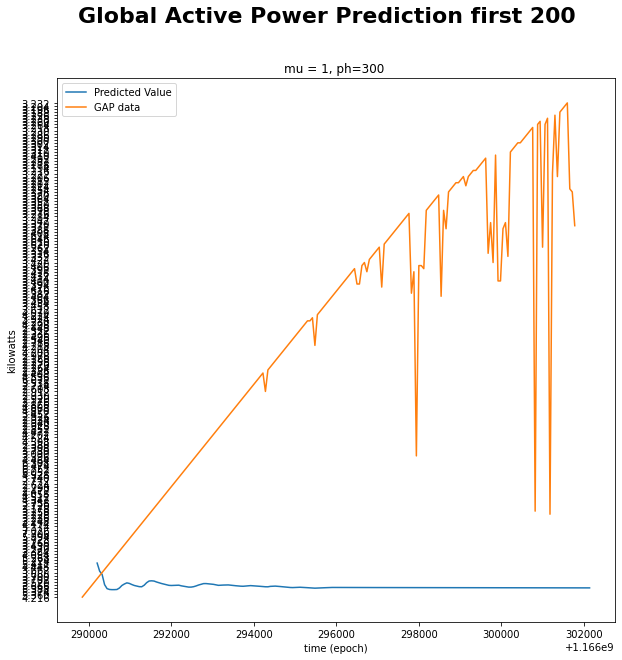

In [128]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction first 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

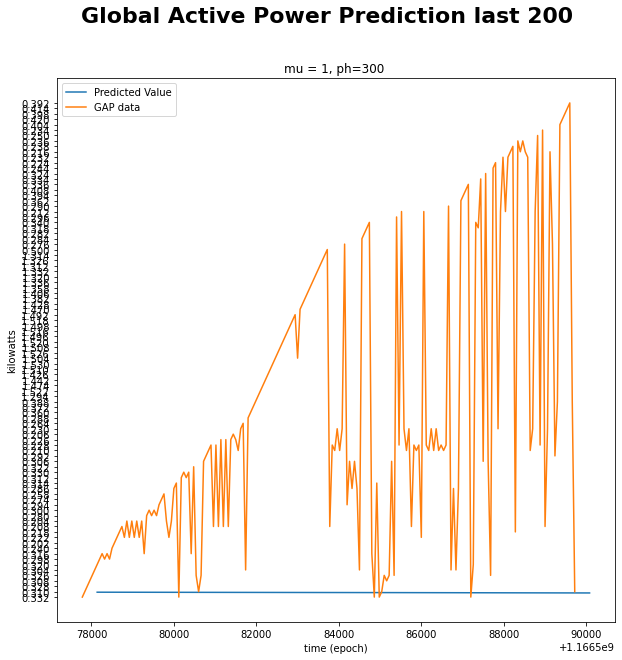

In [129]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[4799:4999,0], ys.iloc[4799:4999,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [130]:
#Calculate RMSE of predictions for mu = 1
rmse = np.sqrt(mean_squared_error(ys.iloc[:4999,0], yp_pred))
print("RMSE: ", rmse)

RMSE:  1.1800497208150043


In [131]:
mu = 0.01
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**((i-k)/ph)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp.values.reshape(-1, 1), ys_tmp.values, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = df['time'].iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

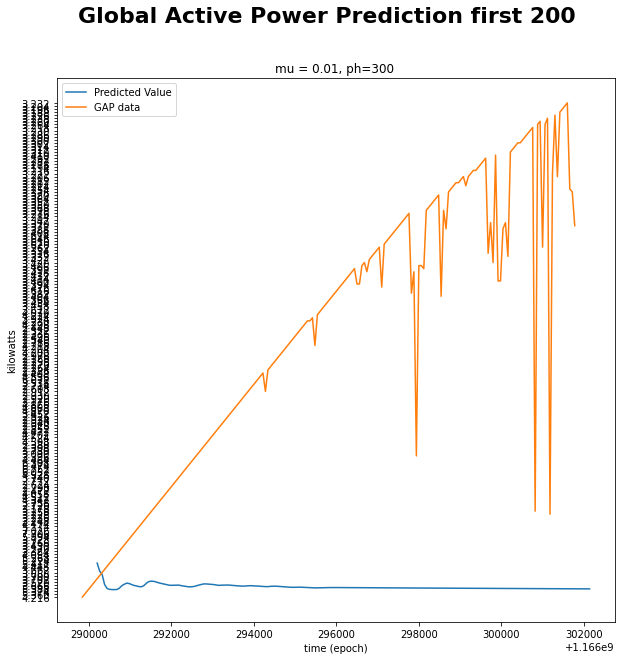

In [132]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction first 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

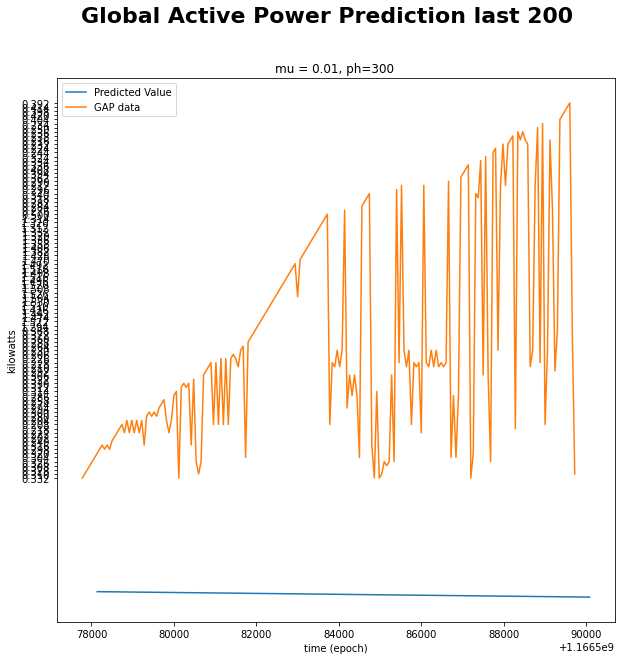

In [133]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[4799:4999,0], ys.iloc[4799:4999,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [134]:
#Calculate RMSE of predictions for mu = 0.01
rmse = np.sqrt(mean_squared_error(ys.iloc[:4999,0], yp_pred))
print("RMSE: ", rmse)

RMSE:  16.72425803063957


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the RMSE tell you?**

A:  for mu = 1 our model performs better than mu = 0 .01 and mu = .9. the early prediction is appsoximatly equal to above prediction. the graph goes down means our model is able able to predict accuralty as the nuber of data points increases. 

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the RMSE tell you?**

A: For value mu = 0.01 the data points have very slight change and it the rsme has incresed by 0.00001 approx when compared to mu = .9 but have a lot of difference when compared to mu =1 as mu =1 is more accurate than the mu = 0.01 and mu = 0.9.
- There is slight  diffrence between the early and late predictions as we can se the line for late prediction goes down as compared to early prediction.
- in our case the value is 16.9 approx which is very high the value between 0.25 - 0.75 is said to be good fit. so we can say that the model performed with an average error of 16.72425803063957 , the model's predictions deviate a lot from the actual values. which is slightly higher than previos prediction.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: 
- After looking comparing all the three charts , we can say that there is  difference with mu' = 1 and mu = 0.9/0.01 after looking at the charts carefully we can say that mu=1 is better than mu =0.9 and m =0.01 as mu = 0.9 and mu =0.01  does not effect much on weights of data points so they are approximatly equal.
- we can say that the model is mu = 1  is better than mu = 0.01 or mu = 0.9.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: There are a number of things that could be done to improve the model and make it more realistic and useful. Some potential options include:

- Incorporating more variables into the model, such as volatge data or information about the global intensity , to provide more context and increase the accuracy of the predictions.

- Using more advanced or specialized models, such as neural networks or gradient boosting, to improve the accuracy and robustness of the predictions.

- Incorporating more data, such as historical consumption data or data from other similar households, to increase the sample size and provide more information for the model to learn from.

- Incorporating regularization techniques to prevent overfitting and improve the generalization of the model to new data.

- Using techniques such as cross-validation to evaluate the performance of the model and fine-tune the parameters.

- Incorporating additional time-series analysis techniques to take account of temporal dependencies in the data.

- Using techniques such as feature selection to select the most important predictors.

- Incorporating techniques such as anomaly detection to identify abnormal patterns in the data and to improve the performance of the model.





**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the RMSE**

In [169]:
df.Voltage.isnull().sum()
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
type(df.Voltage[1])
mean = df["Voltage"].mean()
df.Voltage[1]
df.time[1]
print(df.Voltage.isnull().sum())

df["Voltage"].fillna(mean, inplace=True)
print(df.Voltage.isnull().sum())

0
0


In [176]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df.time)
ts = pd.concat([ts, pd.DataFrame(df.Voltage)], axis=1)
# vs = 
ys = pd.DataFrame(df.Global_active_power)

ph = 5*60 #5 minut
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

25979
0


In [182]:
#run the prediction code on your expanded dataset

for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    # ts_tmp = pd.concat([ts_tmp, df.Voltage.iloc[:i]], axis=1)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**((i-k)/ph)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    # print(m_tmp)


    #use ph to make the model prediction according to the prediction time
    tp =  df['time'].iloc[i-1] + ph
    yp = m_tmp[0][0]*tp + m_tmp[0][1]*df['Voltage'].iloc[i-1] + q_tmp
      
    tp_pred[i-2] = tp 
    # print(yp)  
    yp_pred[i-2] = yp
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

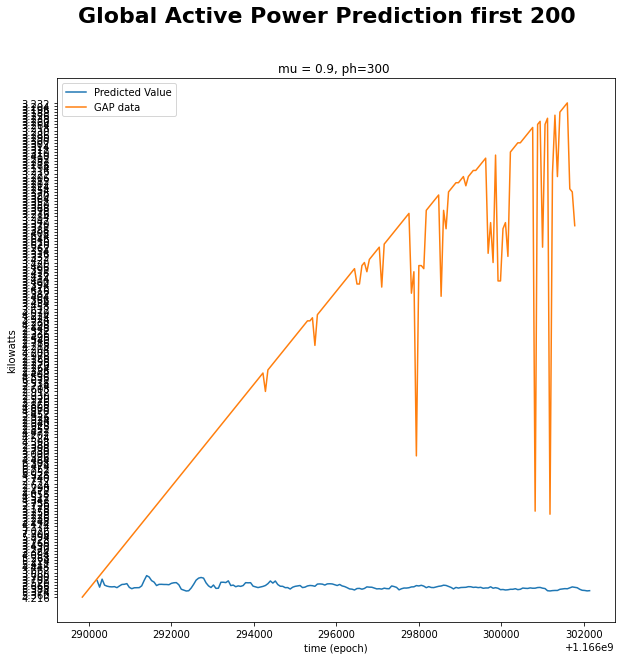

In [183]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction first 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

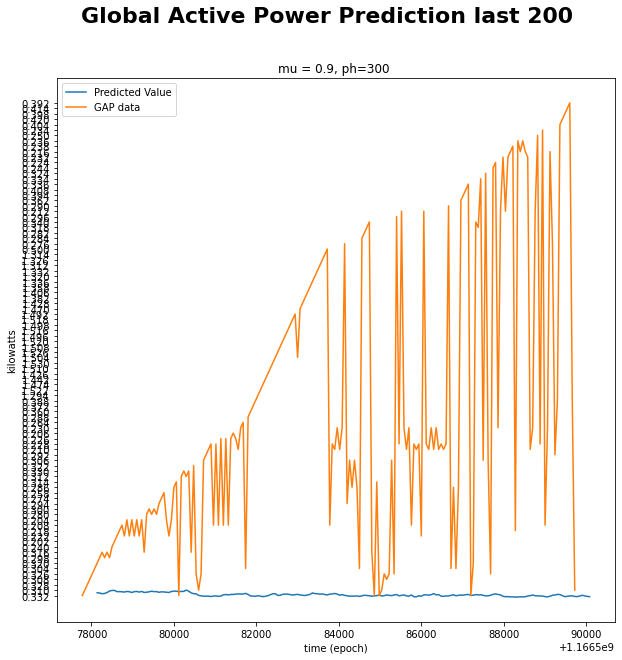

In [184]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[4799:4999,0], ys.iloc[4799:4999,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [185]:
#Calculate RMSE of predictions for the expanded data
rmse = np.sqrt(mean_squared_error(ys.iloc[:4999,0], yp_pred))
print("RMSE: ", rmse)

RMSE:  0.860754717803374


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model perform very accurate from our previous models as we can see that the rmse value is closer to 0.7  which is .86 and better than our prevoius models.
- we can say that adding mode data will increase the accuracy of our model.
- we can say that is the best of all the models for now but we can inprove the accurary more.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: One alternative model that could be used is a moving average model. Instead of using a linear regression model, this model would use the average of the previous n data points as the predicted value for the next data point. This model could improve the current model by smoothing out any short-term fluctuations in the data and providing a more consistent prediction. Additionally, a moving average model is less sensitive to outliers in the data, which can be a problem for linear regression models. It's also easy to implement and can handle missing data


In [215]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
type(df['Global_active_power'][0])
df['Global_active_power'].isnull().sum()
df["Global_active_power"].fillna(mean, inplace=True)
print(df.Global_active_power.isnull().sum())
print(df.time.isnull().sum())
# 
print(type(df.Global_active_power[1]))


0
0
<class 'numpy.float64'>


In [240]:
#create your alternative training data here
window_size = 24 
df['moving_average'] = df['Global_active_power'].rolling(window=window_size).mean()
# df.dropna(inplace=True)

ph = 5*60#5 minutes
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [250]:

df["moving_average"].fillna(mean, inplace=True)
type(df["moving_average"][24])


numpy.float64

In [251]:
df["moving_average"].isnull().sum()

0

In [252]:
#re-run the prediction code here
window_size = 24
for i in range(24, n_s+1):
    # ts_tmp = ts.iloc[:i]
    ys_tmp = df.moving_average.iloc[:i]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**((i-k)/ph)
    weights = np.flip(weights, 0)
    
    #calculate moving average
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(df['time'].iloc[:i].values.reshape(-1, 1), ys_tmp.values,sample_weight=weights)
    
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_
    #make prediction based on last moving average value
    tp = df['time'].iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-24] = tp    
    yp_pred[i-24] = yp

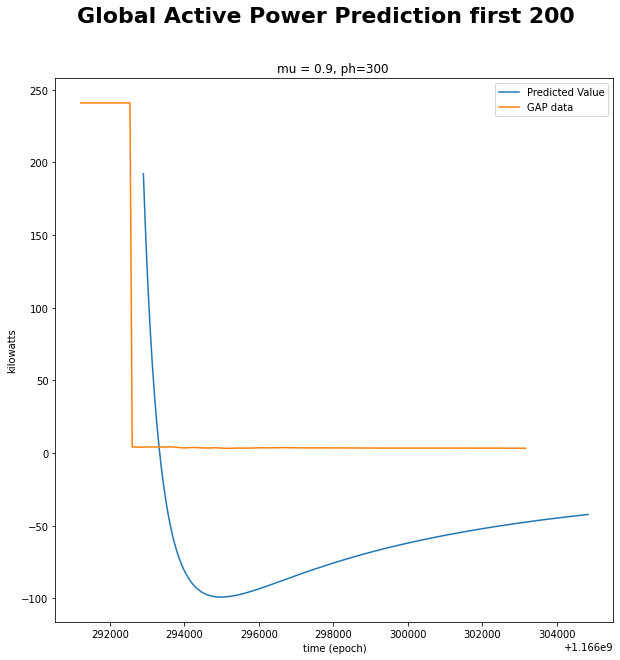

In [264]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction first 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(df['time'].iloc[0:200], df['moving_average'].iloc[0:200], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

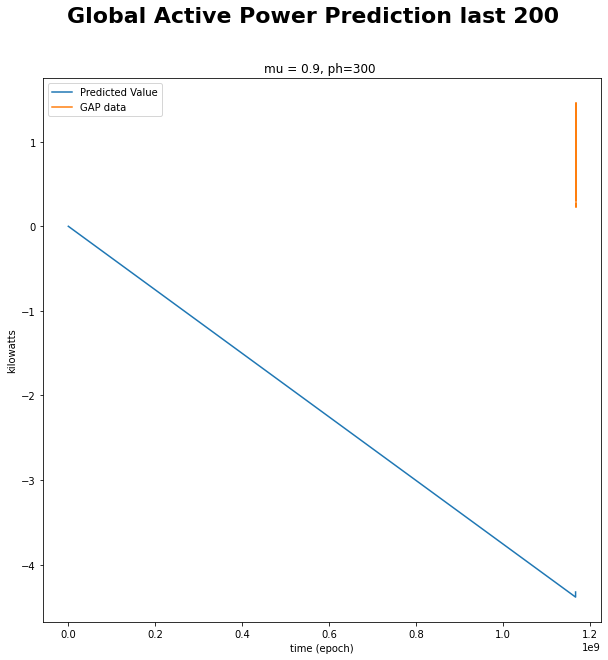

In [268]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction last 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(df['time'].iloc[4799:4999], df['moving_average'].iloc[4799:4999], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [270]:
#Calculate RMSE of predictions for alternative model
rmse = np.sqrt(mean_squared_error(df['moving_average'].iloc[:4999], yp_pred))
print("RMSE: ", rmse)

RMSE:  25.383812875977082


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: No the alternative model did not improve the the result as compared with our previous models after taking moving avegare of window size 24 minutes the accuracy reduced and but for the initial data points it is similar with the actual values.
- conculsion is that using the above model the accuraccy got decreased as compared to previous models.
- To improve the model while still using linear regression, one could try:

 - Adding more features or variables to the model to capture more information about the data
 - Regularizing the model to prevent overfitting
 - Using a non-linear model such as polynomial regression or a decision tree
 - Using a different machine learning algorithm such as random forest or gradient boosting
 - Applying feature scaling to the data to help the model converge faster
 - Experimenting with different window sizes for the moving average
 - Using multiple linear regression models with different window sizes or different features and then ensemble them to create a more robust model.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.